<a href="https://colab.research.google.com/github/FireShadow05/Anime-Face-Generation/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/model.zip -d /content/dataset

In [282]:
# Root directory for dataset
dataroot = "./dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

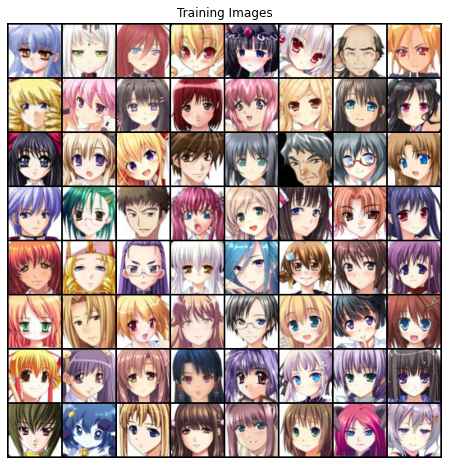

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [284]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,stride = 1, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels,track_running_stats=False)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = out + residual
        return out

class Block_2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Block_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,stride = 1, kernel_size = 3, padding = 1)
        self.Pixle = nn.PixelShuffle(2)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        out = self.conv1(x)
        out = self.Pixle(out)
        out = self.bn1(out)
        out = self.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self,in_channels,layers):
        super(Generator, self).__init__()
        self.dnn1 = nn.Sequential(
            nn.Linear(128,64*16*16),
            nn.BatchNorm1d(64*16*16),
            nn.ReLU(inplace = False)
        )
        self.block = self.make_layer(64,64,layers[0])
        self.batch1 = nn.BatchNorm2d(64)
        self.block2 = self.make_layer_2(64,256,layers[1])
        self.relu = nn.ReLU(inplace = False)
        self.m = nn.Tanh()
        self.conv1 = nn.Conv2d(64,3,stride = 1, kernel_size = 9, padding = 4)

    def make_layer(self,in_channels,out_channels,layer):
        layers = []
        layers.append(ResidualBlock(in_channels,out_channels))
        for i in range(layer-1):
            layers.append(ResidualBlock(out_channels,out_channels))
        return nn.Sequential(*layers)

        
    def make_layer_2(self,in_channels,out_channels,layer):
        layers = []
        for i in range(layer):
            layers.append(Block_2(in_channels,out_channels))
        return nn.Sequential(*layers)

    def forward(self,x,batch):
        out = self.dnn1(x)
        residual = out.view(batch,64,16,16)
        out = self.block(out.view(batch,64,16,16))
        out = self.batch1(out)
        out = self.relu(out)
        out = out + residual
        out = self.block2(out)
        out = self.conv1(out)
        out = self.m(out)
        return out

In [285]:
g = Generator(128,[16,2]).to(device)

In [286]:
class generator_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(generator_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,stride = 1, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels,track_running_stats=False)
        self.lr1 = nn.LeakyReLU(inplace=False)
        self.lr2 = nn.LeakyReLU(inplace=False)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.lr1(out)
        out += residual
        out = self.lr2(out)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3,32,stride = 2, kernel_size = 4, padding = 1)
        self.lr1 = nn.LeakyReLU(inplace=False)
        self.layer = self.make_layer(32,8)
        self.fc = nn.Linear(512,2)
        self.sigmoid = nn.Sigmoid()

    def make_layer(self,channels,layer):
        layers = []
        for i in range(layer-1):
            layers.append(generator_block(channels,channels))
            k = 4
            if channels > 128:
                k = 3
            if i%2 == 1:
                channels *= 2
                layers.append(nn.Conv2d(channels//2,channels,stride = 2, kernel_size = k, padding = 1))
                layers.append(nn.LeakyReLU(inplace=False))
        layers.append(nn.Conv2d(channels,channels*2,stride = 2, kernel_size = 3))
        layers.append(nn.LeakyReLU(inplace=False))
        return nn.Sequential(*layers)

    def forward(self,x,batch):
        out = self.conv1(x)
        out = self.lr1(out)
        out = self.layer(out)
        out = self.fc(out.view(batch,512))
        return self.sigmoid(out)

In [287]:
d = Discriminator().to(device)

In [288]:
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(d.parameters(), lr=lr,betas = (beta1,0.999))
optimizerG = torch.optim.Adam(g.parameters(), lr=lr,betas = (beta1,0.999))

In [289]:
g_loss = []
d_loss = []
for epoch in range(num_epochs):
# For each batch in the dataloader
    for i, images in enumerate(dataloader):
        real = images[0].to(device)
        batch = len(real)
        output_real = d(real,batch)
        d.zero_grad()
        lossR = criterion(output_real,nn.functional.one_hot(torch.ones((batch),dtype = torch.int64),num_classes = 2).type(torch.float).to(device))
        lossR.backward()
        fake = g(torch.rand(batch,128).to(device),batch)
        output_fake = d(fake.detach(),batch)
        lossF = criterion(output_fake,nn.functional.one_hot(torch.zeros((batch),dtype = torch.int64),num_classes = 2).type(torch.float).to(device))
        lossF.backward()
        optimizerD.step()
        g.zero_grad()
        output_fake = d(fake,batch)
        lossG = criterion(output_fake,nn.functional.one_hot(torch.ones((batch),dtype = torch.int64),num_classes = 2).type(torch.float).to(device))
        lossG.backward()
        d_loss.append((lossR + lossF).item())
        g_loss.append(lossG.item())
        optimizerG.step()
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


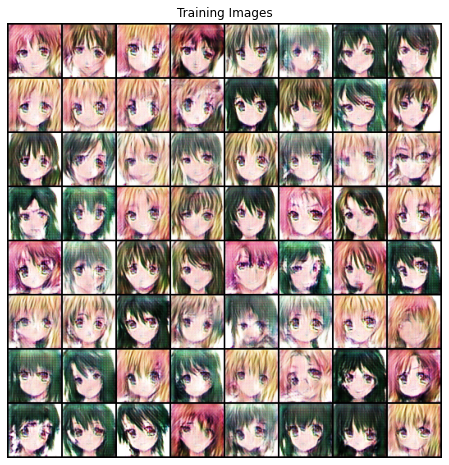

In [290]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(g(torch.rand(128,128).to(device),128).to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

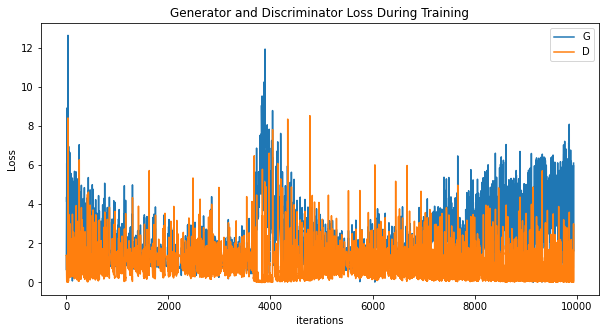

In [291]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()